In [67]:
import numpy as np
import pandas as pd
import os
import pickle

# Other packages
import analyzer.loaders.cremona.utils as u
import analyzer.loaders.cremona as cremona
import analyzer.loaders.hmfundacion.hmfundacion as hmfundacion
from analyzer.utils import store_json, change_SaO2
import analyzer.dataset as ds

import shap

# import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default='browser'

In [77]:
import matplotlib.pyplot as plt

## Load Model and Data

Select model type.  
- **model_type** = 'mortality' or 'infection'
- **model_lab** = 'with_lab' or 'without_lab'

In [136]:
model_type = 'infection'
model_lab = 'with_lab'

assert model_type in('mortality','infection'), "Invalid outcome"
assert model_lab in('with_lab','without_lab'), "Invalid lab specification"

In [137]:
prediction

'Swab'

Set paths for data/model loading

In [138]:
website_path = '/Users/hollywiberg/git/website/'
path_cremona = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_cremona/data/'
path_hm = '/Users/hollywiberg/Dropbox (MIT)/COVID_risk/covid19_hmfoundation/'

Load model corresponding to *model_type* and *model_lab*.

In [139]:
with open(website_path+'assets/risk_calculators/'+model_type+'/model_'+model_lab+'.pkl', 'rb') as file:
    model_file = pickle.load(file)
    
model = model_file['model']
features = model_file['json']
columns = model_file['columns']

In [140]:
SEED = 1

## Variables determined by input
prediction = 'Outcome'if model_type == 'mortality' else 'Swab'
swabs_data = False if model_type == 'mortality' else True
comorbidities_data = True if model_type == 'mortality' else False
lab_tests = True if model_lab == 'with_lab' else False

# ## Constant variables
extra_data = False
demographics_data = True
discharge_data = True
vitals_data = True

name_datasets = np.asarray(['discharge', 'comorbidities', 'vitals', 'lab', 'demographics', 'swab'])
mask = np.asarray([discharge_data, comorbidities_data, vitals_data, lab_tests, demographics_data, swabs_data])
print(name_datasets[mask])

## Load Cremona data
data = cremona.load_cremona(path_cremona, discharge_data, comorbidities_data, vitals_data, lab_tests, demographics_data, swabs_data)
X_cremona, y_cremona = ds.create_dataset(data, discharge_data, comorbidities_data, vitals_data,
                                      lab_tests, demographics_data, swabs_data, prediction = prediction)

if model_type == "mortality":
    ## Load Spain data
    data_spain = hmfundacion.load_fundacionhm(path_hm, discharge_data, comorbidities_data, vitals_data, lab_tests, demographics_data, extra_data)
    X_spain, y_spain =  ds.create_dataset(data_spain, discharge_data, comorbidities_data, vitals_data,
                                          lab_tests, demographics_data, swabs_data, prediction = prediction)

    # Merge datasets, filter outliers, match format of stored model
    X = pd.concat([X_cremona, X_spain], join='inner', ignore_index=True)
    y = pd.concat([y_cremona, y_spain], ignore_index=True)
else: 
    X, y = X_cremona, y_cremona

X, bounds_dict = ds.filter_outliers(X)
X = X[columns] 

['discharge' 'vitals' 'lab' 'demographics' 'swab']
ABG: Base Excess: LB = -19.0, UB = 9.0 (Filter = 1)
ABG: COHb: LB = 0.0, UB = 4.0 (Filter = 0)
ABG: Lactic Acid: LB = 0.0, UB = 10.0 (Filter = 1)
ABG: MetHb: LB = 0.0, UB = 1.0 (Filter = 0)
ABG: Oxygen Saturation (SaO2): LB = 33.0, UB = 100.0 (Filter = 1)
ABG: PaCO2: LB = 15.0, UB = 58.0 (Filter = 1)
ABG: PaO2: LB = 20.0, UB = 263.0 (Filter = 2)
ABG: pH: LB = 7.0, UB = 8.0 (Filter = 0)
ABG: standard bicarbonate (sHCO3): LB = 10.0, UB = 33.0 (Filter = 1)
Activated Partial Thromboplastin Time (aPTT): LB = 0.0, UB = 4.0 (Filter = 0)
Age: LB = 0.0, UB = 100.0 (Filter = 0)
Alanine Aminotransferase (ALT): LB = 3.0, UB = 258.0 (Filter = 2)
Aspartate Aminotransferase (AST): LB = 13.0, UB = 406.0 (Filter = 1)
Blood Amylase: LB = 13.0, UB = 362.0 (Filter = 1)
Blood Calcium: LB = 5.0, UB = 11.0 (Filter = 0)
Blood Creatinine: LB = 0.0, UB = 9.0 (Filter = 0)
Blood Sodium: LB = 118.0, UB = 163.0 (Filter = 2)
Blood Urea Nitrogen (BUN): LB = 5.0, UB =

## Evaluate Model with SHAP

In [141]:
shap.initjs()

##### Calculate SHAP values (for each observation x feature)

In [142]:
shap.initjs()

explainer = shap.TreeExplainer(model);
shap_values = explainer.shap_values(X);

##### Summarize SHAP values across all features
This acts as an alterative to the standard variable importance plots. Higher SHAP values translate to higher probability of mortality.

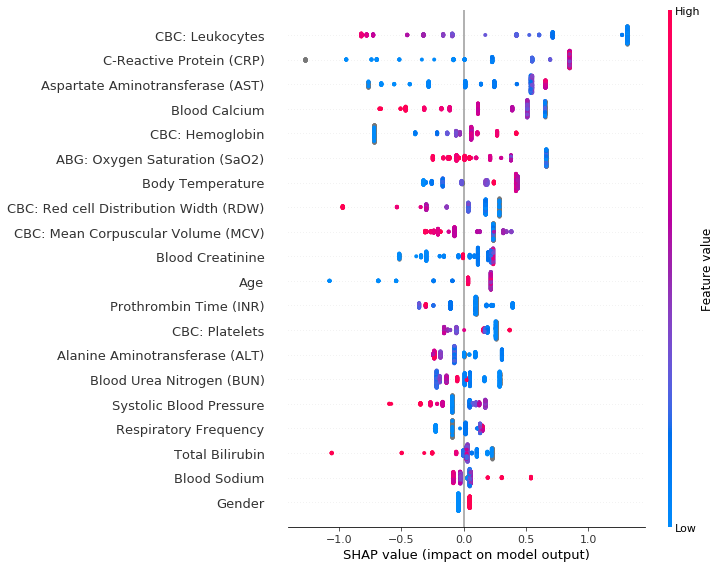

In [143]:
# shap.summary_plot(shap_values, X).
shap.summary_plot(shap_values, X,show=False)
f = plt.gcf()
f.savefig('../results/'+model_type+'/model_'+model_lab+'/summary_plot.png', bbox_inches='tight')

##### Deep-dive into individual features
For a given feature, see how the SHAP varies across its possible values. The interaction_index lets you choose a secondary index to visualize. If omitted, it will automatically find the variable with the highest interaction.

invalid value encountered in true_divide
invalid value encountered in true_divide


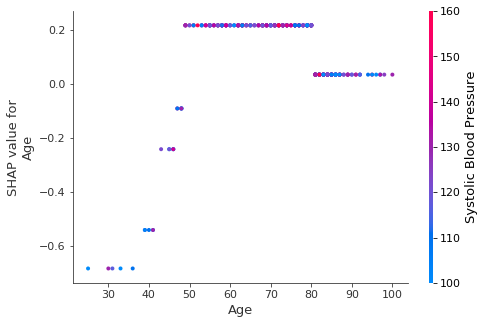

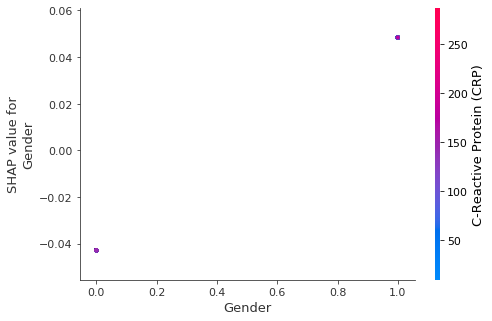

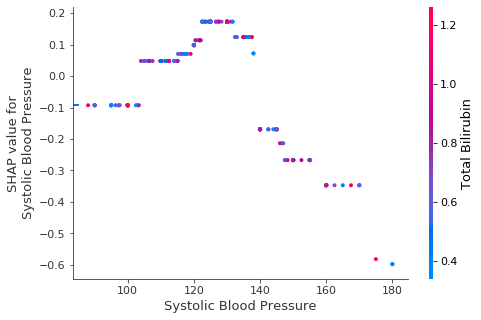

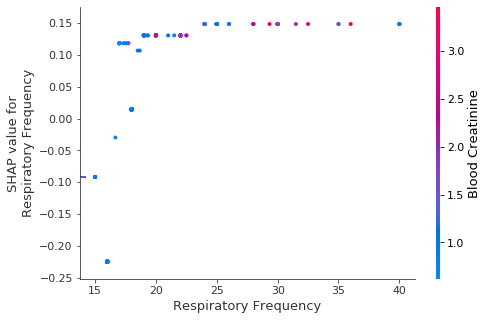

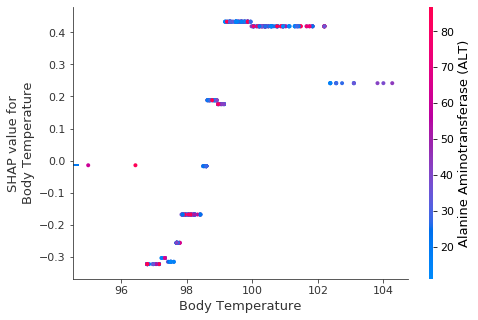

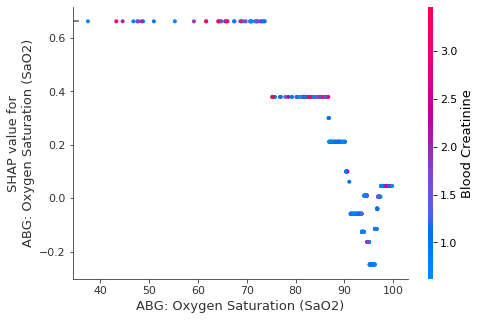

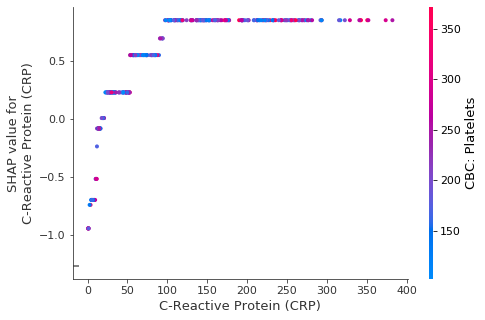

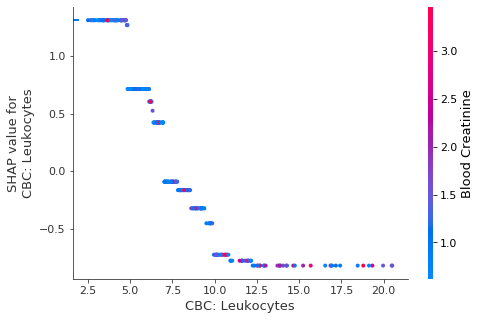

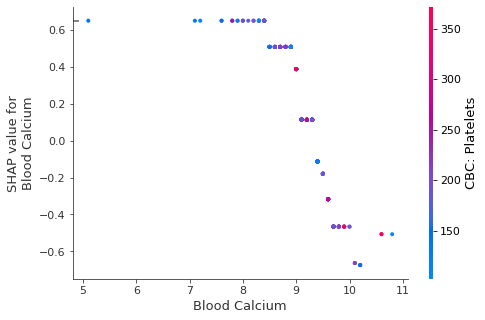

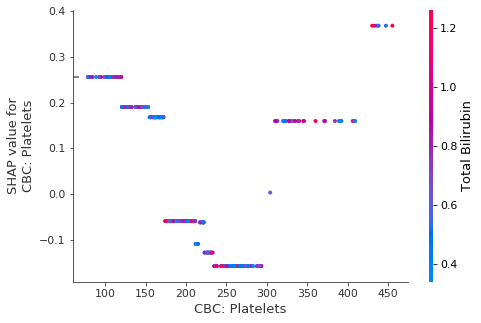

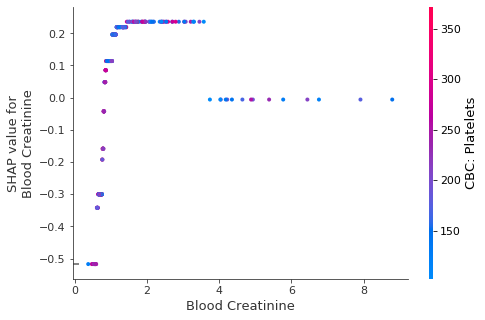

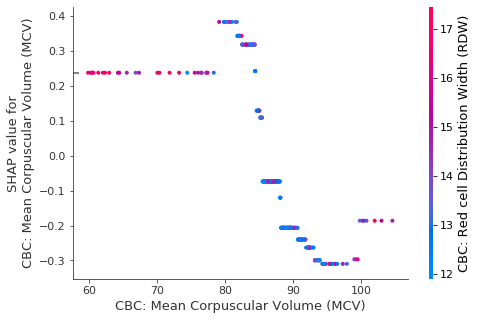

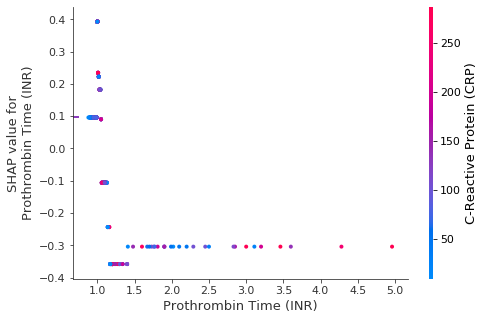

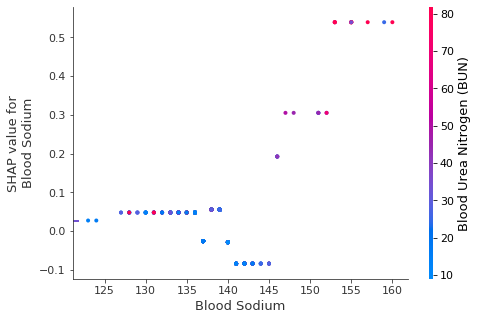

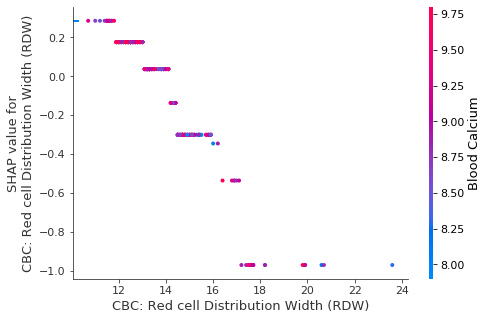

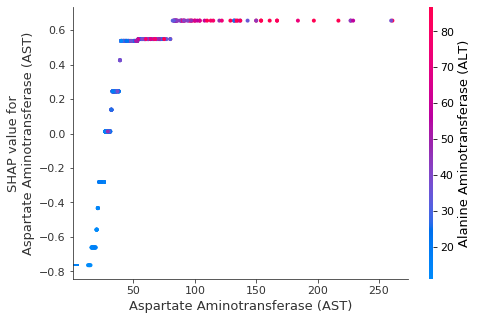

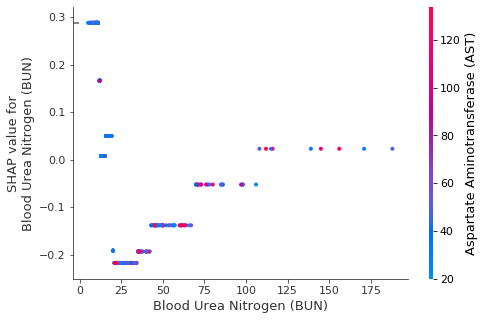

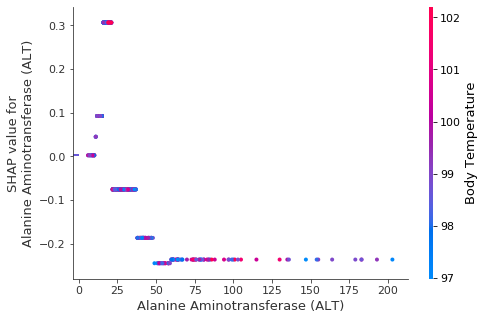

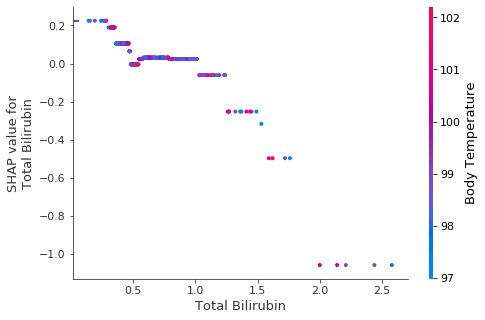

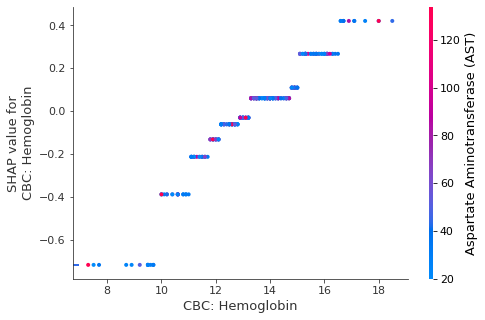

In [144]:
# shap.dependence_plot("Systolic Blood Pressure", shap_values, X, interaction_index = "Age")
for i in X.columns:
    shap.dependence_plot(i, shap_values, X,show=False)
    f = plt.gcf()
    f.savefig('../results/'+model_type+'/model_'+model_lab+'/dependence_plot_'+i+'.png', bbox_inches='tight')

##### Evaluate drivers of individual predictions 
Select index j for prediction to generate.

In [135]:
# shap.force_plot(explainer.expected_value, shap_values[1:10,:], X.iloc[[1:10,:]])
j=20
plot = shap.force_plot(explainer.expected_value, shap_values[j], X.iloc[[j]] , link="logit")
plot

As an alternative view, you can trace a 3D plot of the values and their impact on the prediction.

In [25]:
#